# Modeling

Sources: 

- https://www.kaggle.com/anokas/quora-question-pairs/data-analysis-xgboost-starter-0-35460-lb
- https://www.kaggle.com/puneetsl/quora-question-pairs/unusual-meaning-map 

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
from subprocess import check_output
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# Machine learning
from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split

In [2]:
train_ready = pd.read_csv("Data/modeling/modeling_train_ready.csv").drop('Unnamed: 0',1)
train_ready.head()

,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_share,unigrams_common_count,unigrams_common_ratio,bigrams_common_count,bigrams_common_ratio,train_word_match,tfidf_train_word_match,sentiment_analysis_sum
0,0,0.011247,-0.002436,0.024127,0.003116,0.478261,0.094213,0.833333,0.152692,0.833333,0.909091,0.971435,0.164528
1,0,-0.013628,0.024757,-0.023873,0.007164,0.250000,0.094213,0.416667,0.114230,0.363636,0.461538,0.558679,-0.135472
2,0,0.022856,-0.000682,0.024127,-0.004982,0.166667,-0.016898,0.222222,-0.039616,0.000000,0.363636,0.345326,0.064528
3,0,-0.016945,0.003704,0.000127,-0.009030,0.000000,-0.090972,0.000000,-0.039616,0.000000,0.000000,0.000000,-0.335472
4,0,0.024514,-0.018226,0.016127,-0.017127,0.200000,-0.016898,0.153846,-0.039616,0.000000,0.266667,0.262525,0.164528


In [3]:
#corr = train_ready[0:200]
corr = train_ready[0:80000].iloc[:, 1:].corr()

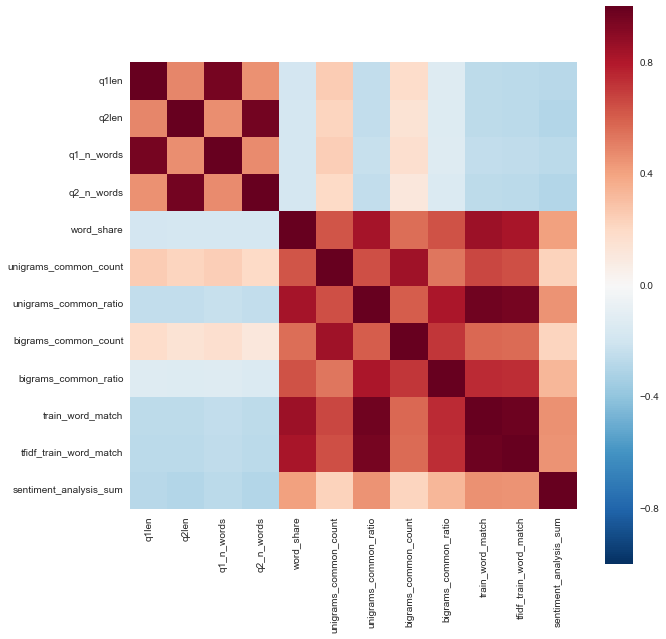

In [4]:
plt.figure(figsize=(10, 10))
sns.heatmap(corr, vmax=1, square=True)

In [5]:
test_ready = pd.read_csv("Data/modeling/modeling_test_ready.csv").drop('Unnamed: 0',1)
test_ready.head()

,test_id,q1len,q2len,q1_n_words,q2_n_words,word_share,unigrams_common_count,unigrams_common_ratio,bigrams_common_count,bigrams_common_ratio,train_word_match,tfidf_train_word_match,sentiment_analysis_sum
0,0,-0.002418,0.007276,-0.000200,0.011753,0.130435,0.037169,0.272727,0.030904,0.166667,0.428571,0.430700,0.113307
1,1,0.004575,-0.014558,0.011897,-0.016473,0.238095,0.069427,0.500000,0.009165,0.111111,0.666667,0.663313,0.213307
2,2,0.000205,-0.026785,0.011897,-0.020505,0.277778,0.037169,0.500000,0.030904,0.400000,0.666667,0.807120,0.213307
3,3,-0.028641,-0.037265,-0.028426,-0.032602,0.000000,-0.059605,0.000000,-0.012574,0.000000,0.000000,0.000000,-0.086693
4,4,-0.026019,-0.025912,-0.028426,-0.020505,0.300000,0.004911,0.666667,0.009165,0.500000,0.800000,1.000000,0.213307


### Data preparation

In [6]:
x_train = train_ready.drop(['is_duplicate'], 1)
x_test = test_ready.drop(['test_id'], 1)

y_train = train_ready['is_duplicate'].values

In [7]:
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.19124366100096607


In [8]:
# Finally, we split some of the data off for validation
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



## XGboost

In [9]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

In [12]:
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.683633	valid-logloss:0.683683
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.606071	valid-logloss:0.606584
[20]	train-logloss:0.551533	valid-logloss:0.552434
[30]	train-logloss:0.511889	valid-logloss:0.513116
[40]	train-logloss:0.482418	valid-logloss:0.483914
[50]	train-logloss:0.460204	valid-logloss:0.461911
[60]	train-logloss:0.443214	valid-logloss:0.445102
[70]	train-logloss:0.430072	valid-logloss:0.43211
[80]	train-logloss:0.419815	valid-logloss:0.421975
[90]	train-logloss:0.411706	valid-logloss:0.413978
[100]	train-logloss:0.40521	valid-logloss:0.40758
[110]	train-logloss:0.400123	valid-logloss:0.40257
[120]	train-logloss:0.395956	valid-logloss:0.398475
[130]	train-logloss:0.392565	valid-logloss:0.395147
[140]	train-logloss:0.389982	valid-logloss:0.392602
[150]	train-logloss:0.387889	valid-logloss:0.390555
[160]	train-logloss:0.386155	val

In [13]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = test_ready['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('xgb.csv', index=False)